# malayalam-MNIST:


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Uni_MNIST')

In [3]:
data_dir='./Indic_MNIST_scans/tif'
os.listdir(data_dir) 

['Dev.TIF', 'Tam.TIF', 'Mal.TIF', 'Kan.TIF', 'Guj.TIF']

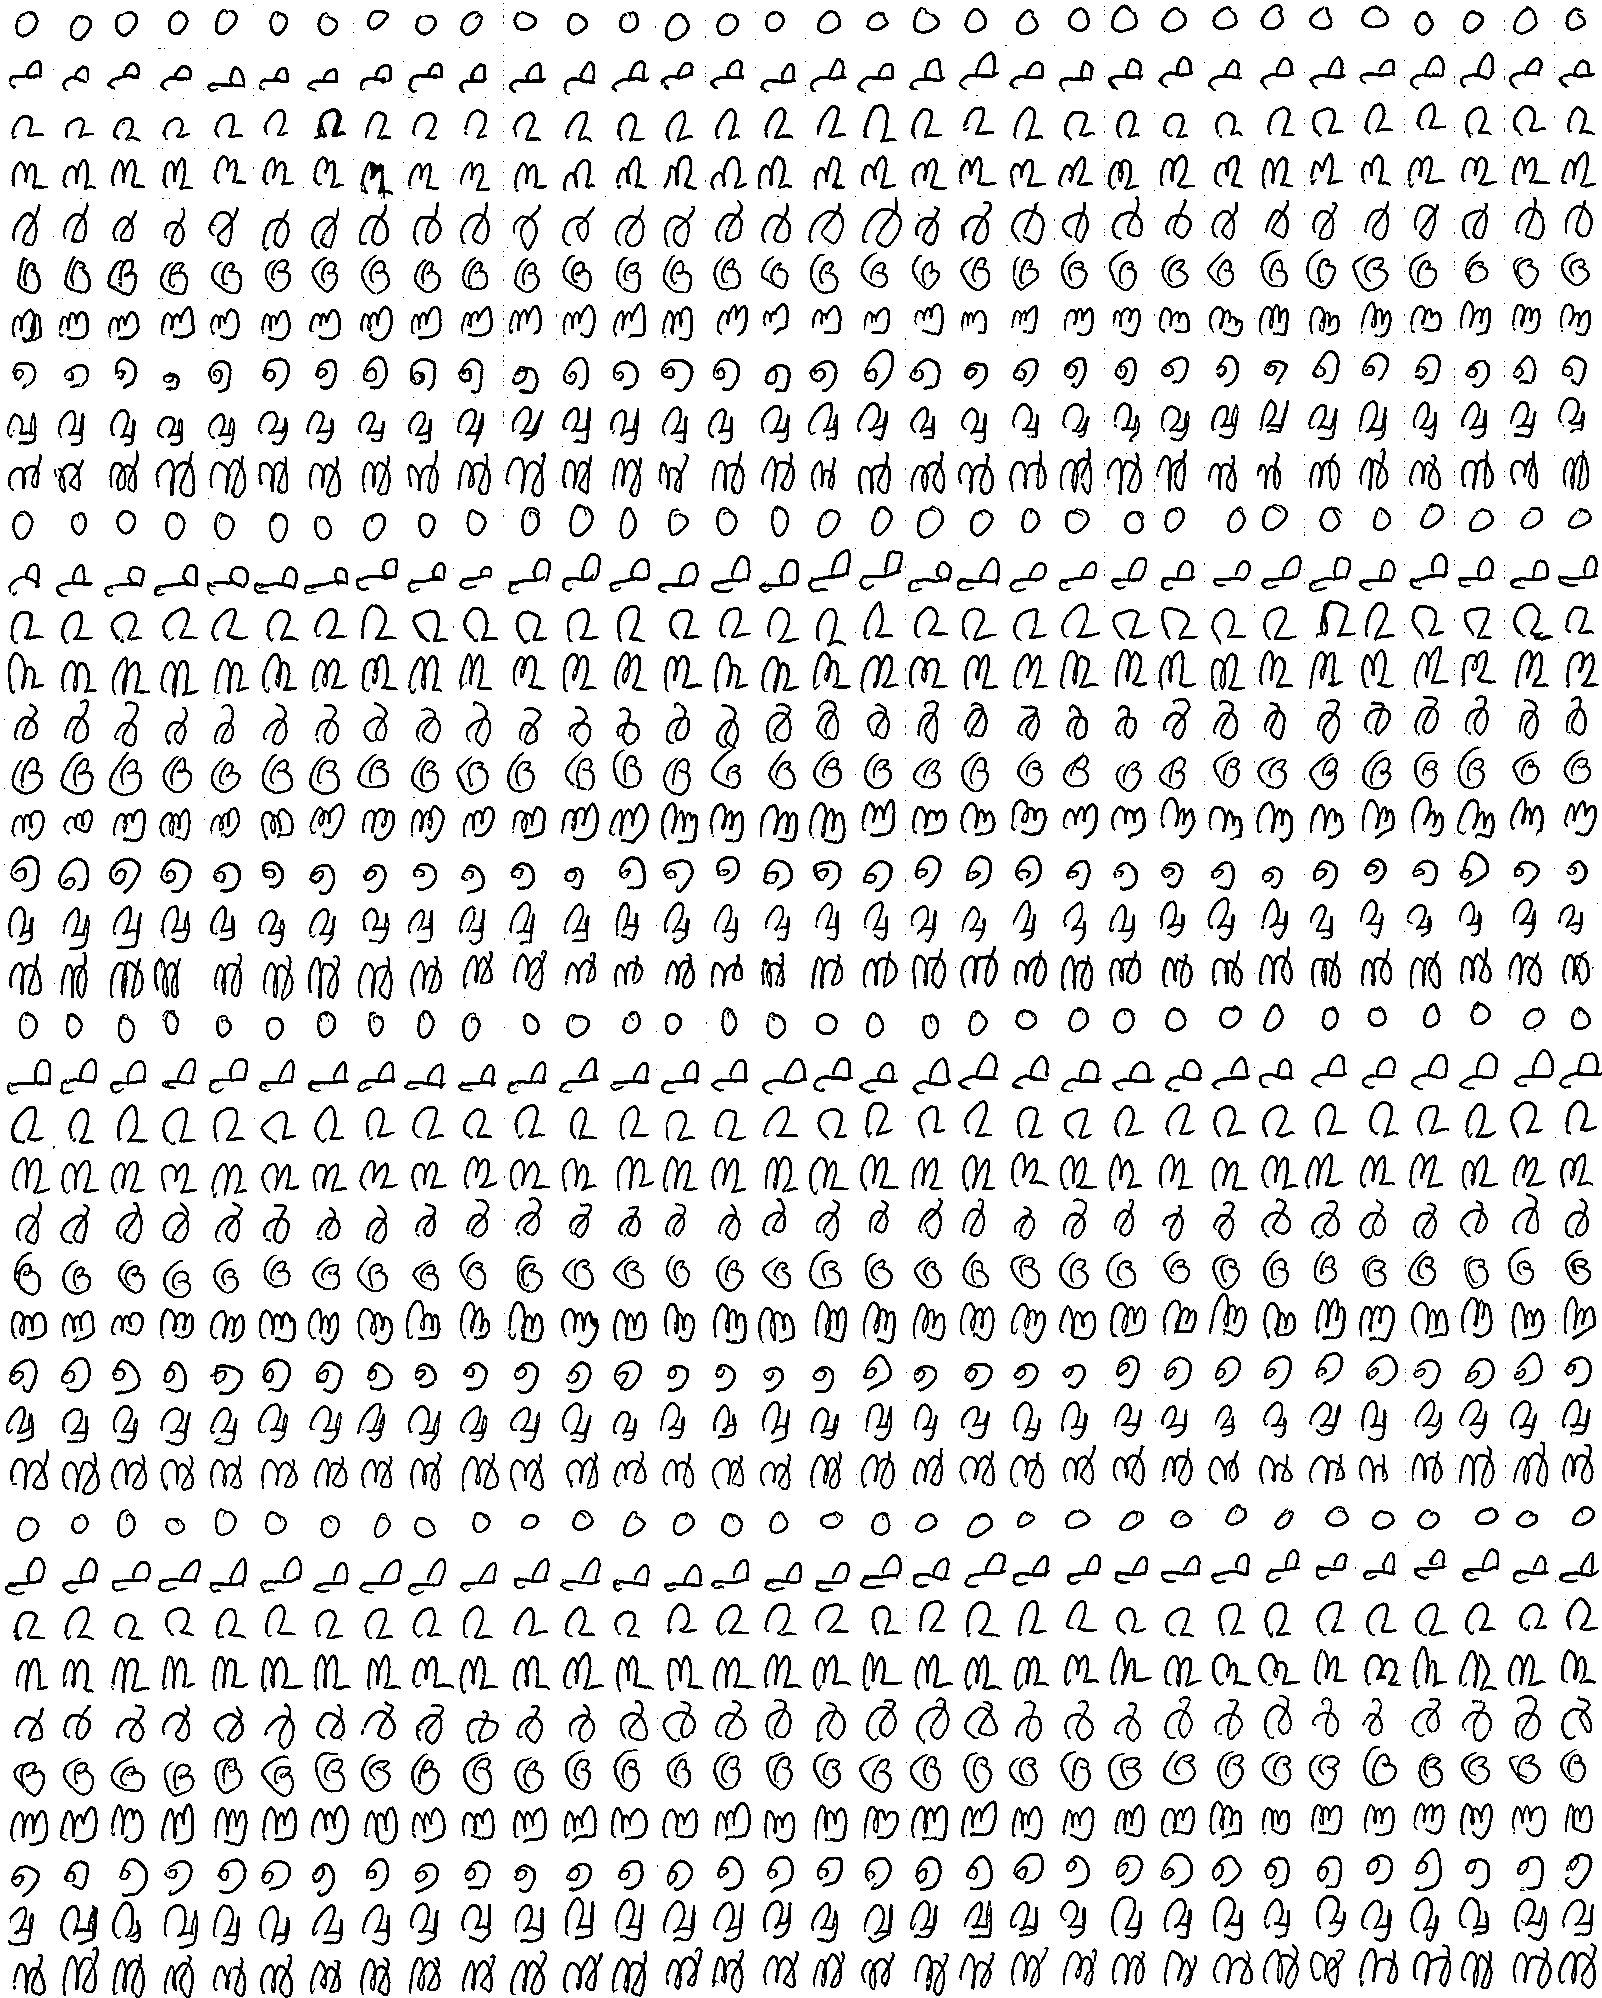

In [4]:
from PIL import Image
im_grid=Image.open(os.path.join(data_dir,'Mal.TIF')).convert('L')
im_grid

In [5]:
im_grid.size

(1602, 1998)

In [0]:
width=im_grid.size[0]/32
height=im_grid.size[1]/40

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm_notebook

The steps involved in generating the image is:


*   Cropping out the box-slice
*   Resize it down to 28 x 28
*   Denosing by thresholding
*   White-background to black-background (Standard MNIST procedure)




In [0]:
from scipy import ndimage
def mnistize(img):
    # Function to take in an image and convert it into standard MNIST format
    # Inverse colors and resize to 28x28
    img = cv2.resize(255-img, (28, 28))
    
    # Binary+Otsu thresholding
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Find tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img,0,1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img,-1,1)
    rows,cols = img.shape
    
    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))
        
    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28-cols)/2.0)), int(np.floor((28-cols)/2.0)))
    rowsPadding = (int(np.ceil((28-rows)/2.0)), int(np.floor((28-rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding,colsPadding), 'constant')
    
    def getBestShift(img):
        cy,cx = ndimage.measurements.center_of_mass(img)

        rows,cols = img.shape
        shiftx = np.round(cols/2.0-cx).astype(int)
        shifty = np.round(rows/2.0-cy).astype(int)

        return shiftx,shifty

    def shift(img,sx,sy):
        rows,cols = img.shape
        M = np.float32([[1,0,sx],[0,1,sy]])
        shifted = cv2.warpAffine(img,M,(cols,rows))
        return shifted

    shiftx, shifty = getBestShift(img)
    img = shift(img, shiftx, shifty)
    
    return img

Pre-processing sanity checks:

1: Qualitative: Do the cropped numbers look 'good'

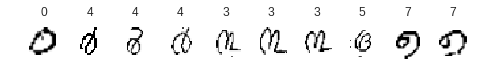

In [9]:
x = np.arange(0,32*width,50)
y = np.arange(0,40*height,50)
xv, yv = np.meshgrid(x, y, indexing='xy')
# Let's take 10 random slices
for trial in range(10):
  i=np.random.randint(0,31)
  j=np.random.randint(0,39)
  k=0
  x,y=(xv[j,i], yv[j,i])
  cropped = im_grid.crop( ( x+2, y+2, x + width , y + height ) ) # Crop the image 
  x_rand_image=mnistize(np.array(cropped)) # MNIST it up!
  plt.subplot(1,10,trial+1)
  plt.imshow(x_rand_image)
  plt.grid(False)
  plt.axis('off')
  plt.title(np.uint8(np.mod(j,10)))#The label
        

2: Quantitative : Pick a digit that looks like a vanilla-MNIST digit and verify if it is indeed predicted as such by a pre-trained off-the-shelf CNN:

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0] 125


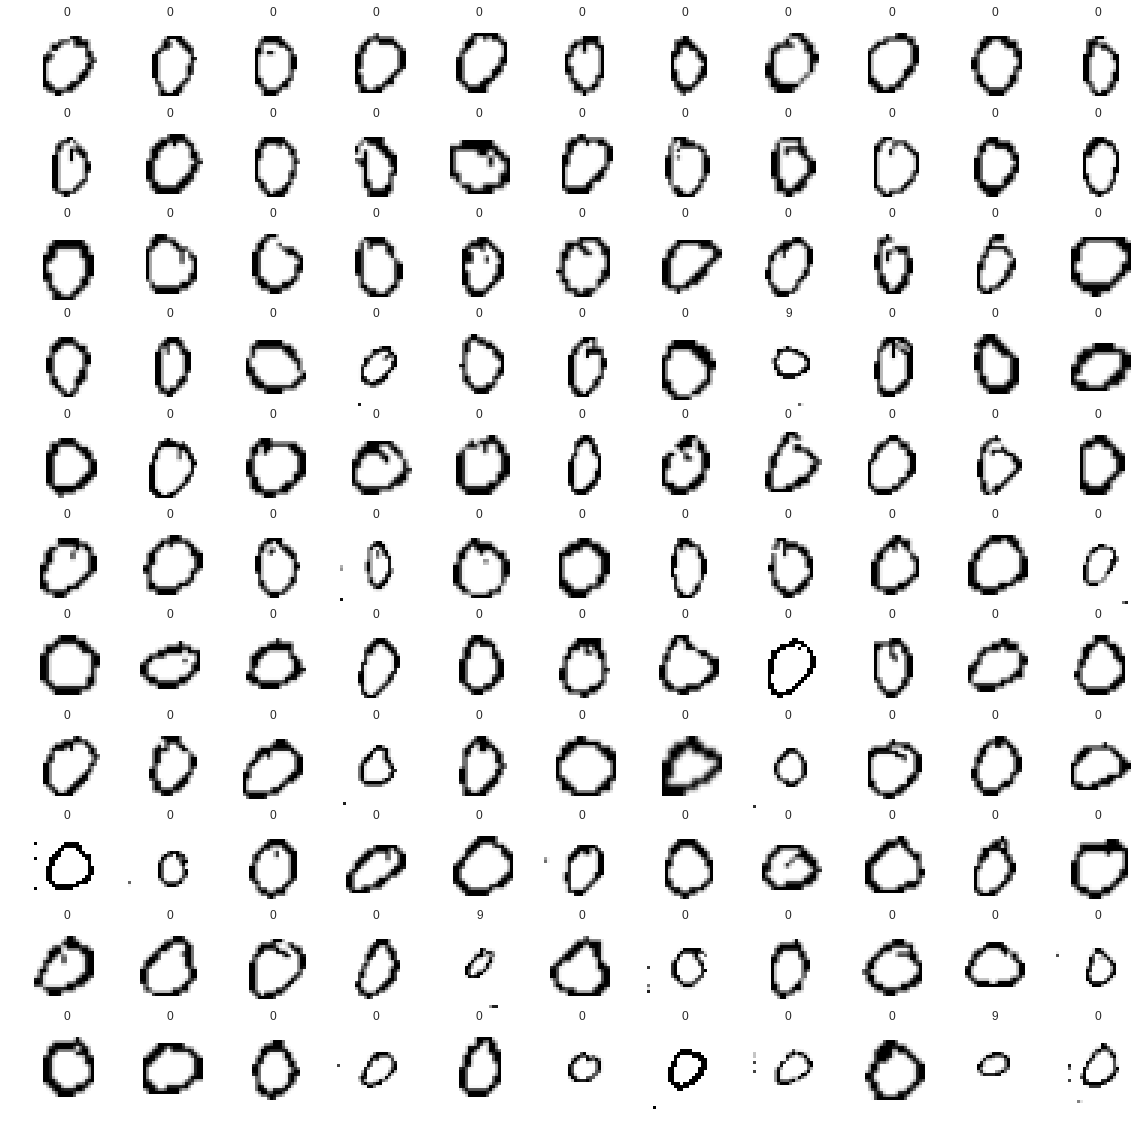

In [10]:
from keras.models import load_model
model=load_model('mnist_english.h5')
################################################
x_sanity_check=np.empty((128,28,28,1),dtype='uint8')

#################################################
#################################################
k=0
for i in tqdm_notebook(range(32)):
    for j in range(40): 
      if(np.mod(j,10)==0):
        
        x,y=(xv[j,i], yv[j,i])
        x1= np.clip(x+2,0,im_grid.size[0])
        y1= np.clip(y+2,0,im_grid.size[1])
        x2= np.clip(x + width ,0,im_grid.size[0])
        y2= np.clip(y+height,0,im_grid.size[1])
        cropped = im_grid.crop( ( x1, y1, x2 , y2 ) ) # Crop the image 
        x_sanity_check[k,:,:,0]=mnistize(np.array(cropped)) # MNIST it up!
        k+=1

        
y_sanity_check=model.predict_classes(x_sanity_check)
print(y_sanity_check,(y_sanity_check==0).sum())
plt.figure(figsize=(20,20))
for i in range(121):
  plt.subplot(11,11,i+1)
  plt.imshow(x_sanity_check[i,:,:,0])
  plt.title(y_sanity_check[i])
  plt.axis('off')

If both the qualitative and quantitative checks have passed,  run the extraction procedure over the entire grid

In [11]:
#################################################
#################################################
x = np.arange(0,32*width,50)
y = np.arange(0,40*height,50)
xv, yv = np.meshgrid(x, y, indexing='xy')
# Initialze the X and y tensors
X_test_imnist=np.empty((32*40,28,28,1),dtype='uint8')
y_test_imnist=np.empty(32*40,dtype='uint8')
#################################################
#################################################
k=0
for i in tqdm_notebook(range(32)):
    for j in range(40):        
      x,y=(xv[j,i], yv[j,i])
      x1= np.clip(x+2,0,im_grid.size[0])
      y1= np.clip(y+2,0,im_grid.size[1])
      x2= np.clip(x + width ,0,im_grid.size[0])
      y2= np.clip(y+height,0,im_grid.size[1])
      cropped = im_grid.crop( ( x1, y1, x2 , y2 ) ) # Crop the image 
      X_test_imnist[k,:,:,0]=mnistize(np.array(cropped)) # MNIST it up!
      y_test_imnist[k]=np.uint8(np.mod(j,10)) # Get the label
      k+=1
#################################################
#################################################

# Post-processing sanity checks:

Sanity-check-1: Visual inspection:


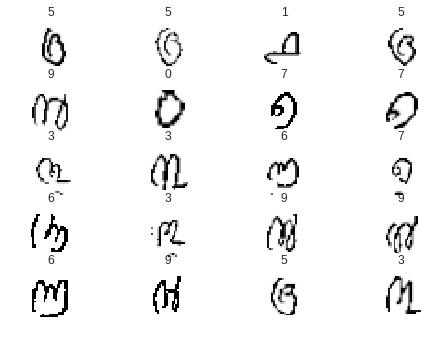

In [12]:
for i in range(20):
  k=np.random.randint(0,32*40-1)
  plt.subplot(5,4,i+1)
  plt.imshow(X_test_imnist[k,:,:,0])
  plt.axis('off')
  plt.title(y_test_imnist[k])

Sanity-check-2 : Classwise histogram

<StemContainer object of 3 artists>

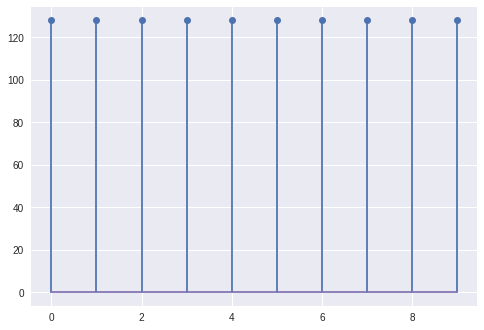

In [13]:
plt.stem(np.bincount(y_test_imnist))

Sanity check-3: Classwise-mean images

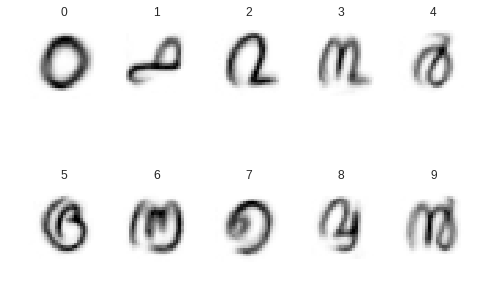

In [14]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(np.mean(X_test_imnist[y_test_imnist==i,:,:,0],axis=0))
  plt.axis('off')
  plt.title(i)

Neat. Now save the $x$ and $y$ tensors:

In [0]:
np.save('X_test_Mmnist.npy',X_test_imnist)
np.save('y_test_Mmnist.npy',y_test_imnist)